In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import classification_report,roc_curve, auc,roc_auc_score,accuracy_score,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.svm import SVC,LinearSVC,NuSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,cross_val_score
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [16]:
path="C:/Users/sande/Downloads/Master.csv"
Master=pd.read_csv("C:/Users/sande/Downloads/Master.csv",low_memory=False)

In [17]:
Master.drop(['Unnamed: 0','id'],axis=1,inplace=True)

In [18]:
pct_na=Master.isna().sum()/len(Master)
per_70_miss=list(pct_na[pct_na>=.7].index)
Master.drop(per_70_miss,axis=1,inplace=True)

In [19]:
Master.loan_status.replace('Does not meet the credit policy. Status:Fully Paid','Fully Paid',inplace=True)
Master.loan_status.replace('Does not meet the credit policy. Status:Charged Off','Charged Off',inplace=True)

In [20]:
Master=Master[Master.loan_status.isin(["Fully Paid","Charged Off"])]

In [21]:
Master.int_rate=Master.int_rate.str.strip("%").astype(float)

In [23]:
Master=Master[["dti","int_rate", "fico_range_low", "home_ownership","loan_amnt", "loan_status","purpose","delinq_2yrs","inq_last_6mths"]].reset_index() 
Master.shape

(1570068, 10)

In [24]:
Master.drop(['index'],axis=1,inplace=True)

In [25]:
Master.home_ownership.replace('ANY','OTHER',inplace=True)
Master.home_ownership.replace('NONE','OTHER',inplace=True)

In [12]:
Master.home_ownership.value_counts(dropna=False)

MORTGAGE    774743
RENT        620557
OWN         171240
OTHER          779
Name: home_ownership, dtype: int64

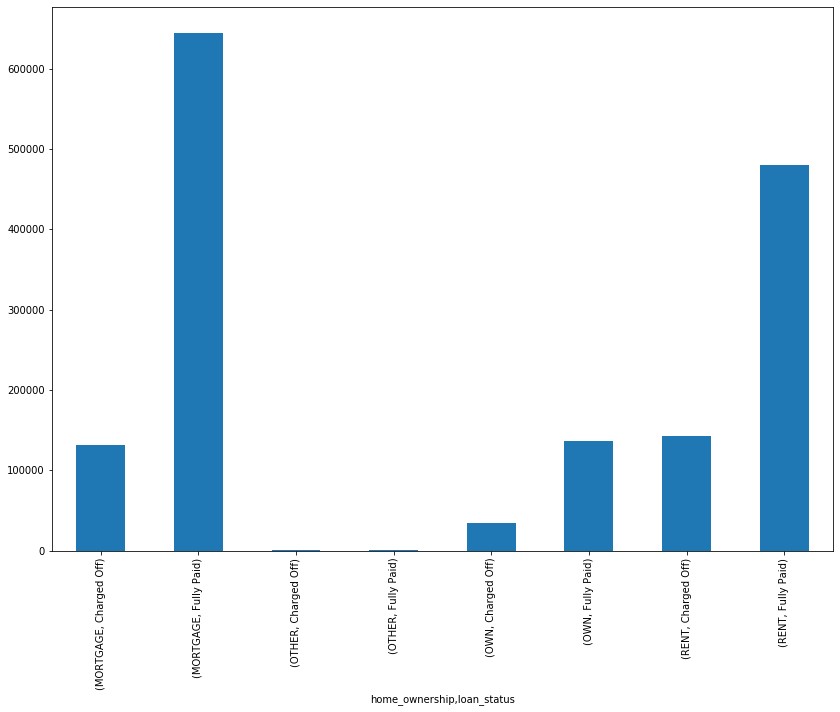

In [32]:
Master[["home_ownership","loan_status"]].groupby(["home_ownership","loan_status"])["home_ownership"].count().plot(kind='bar',figsize=(14,10))

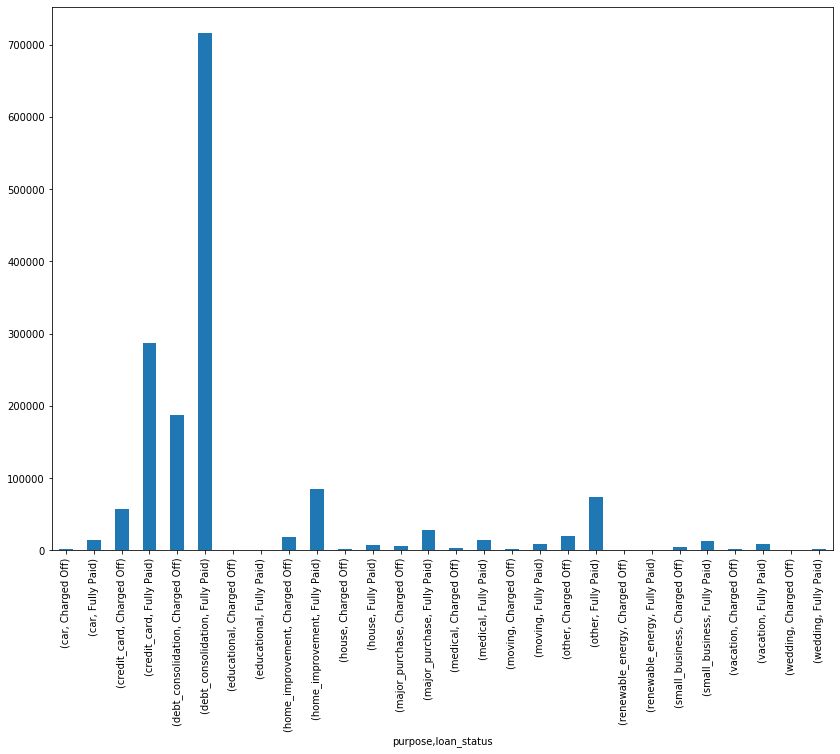

In [14]:
Master[["purpose","loan_status"]].groupby(["purpose","loan_status"])["purpose"].count().plot(kind='bar',figsize=(14,10))

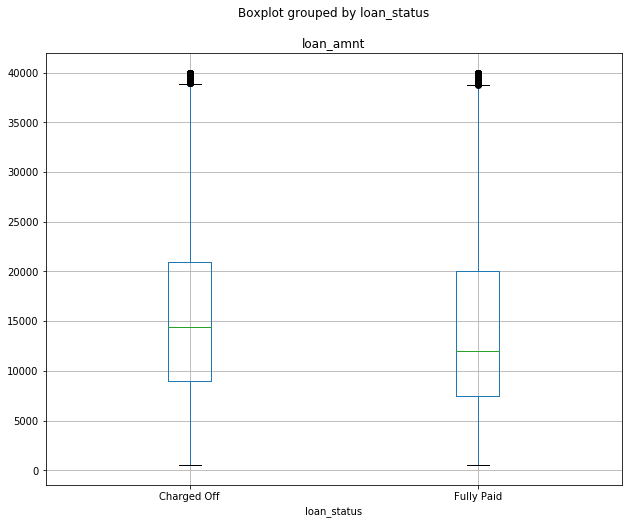

In [15]:
Master.boxplot(column=["loan_amnt"],by="loan_status",figsize=(10,8))

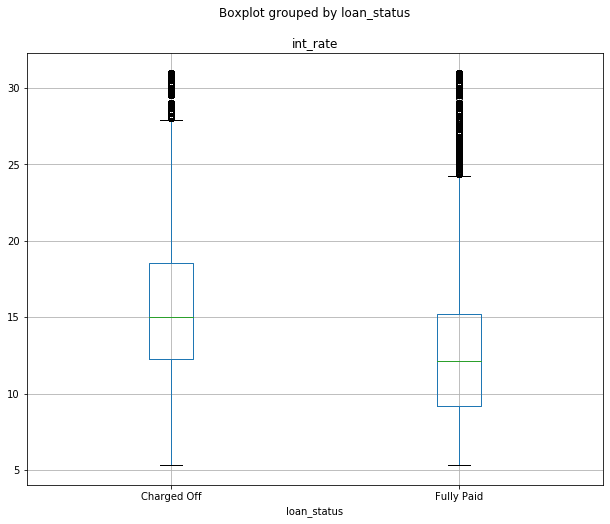

In [16]:
Master.boxplot(column=["int_rate"],by="loan_status",figsize=(10,8))

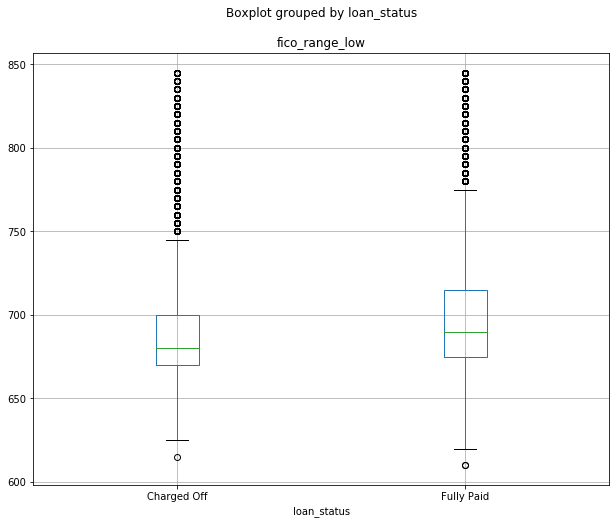

In [17]:
Master.boxplot(column=["fico_range_low"],by="loan_status",figsize=(10,8))

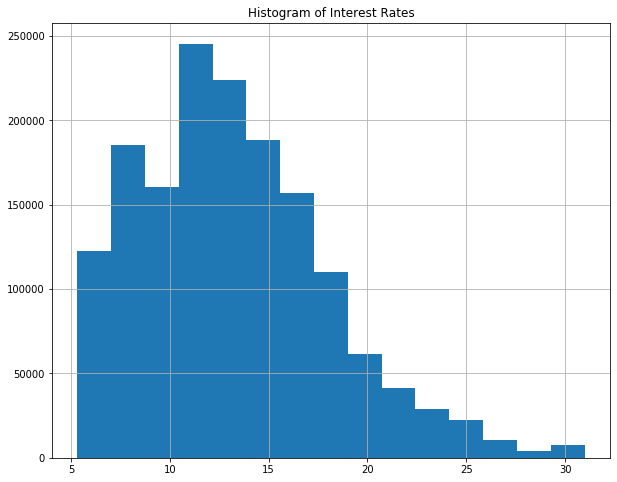

In [29]:
plt.title("Histogram of Interest Rates")
Master.int_rate.hist(bins=15,figsize=(10,8))

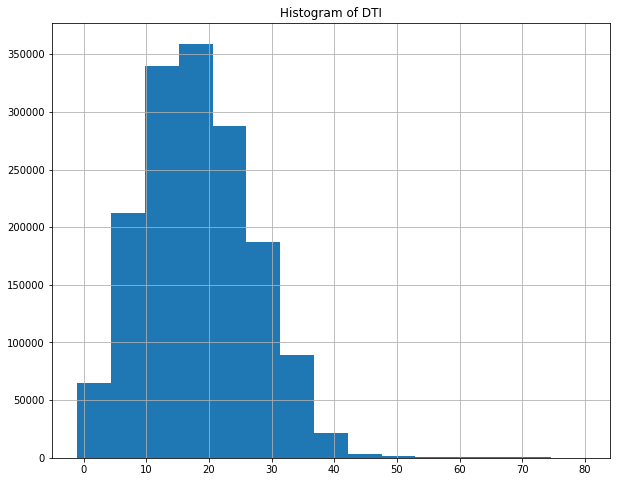

In [28]:
plt.title("Histogram of DTI")
Master.dti[Master.dti<80].hist(bins=15,figsize=(10,8))

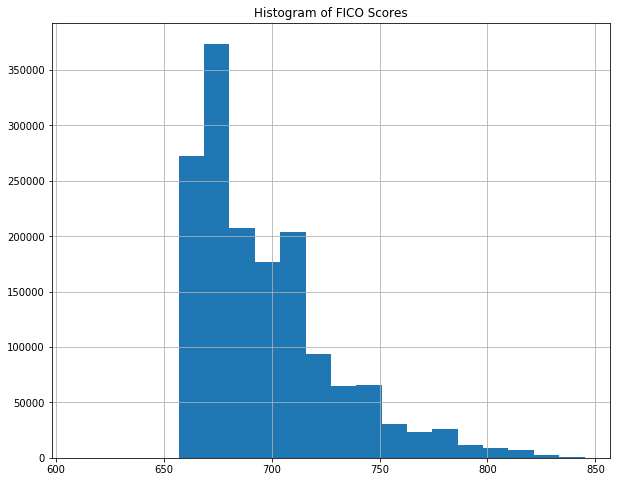

In [31]:
plt.title("Histogram of FICO Scores")
Master.fico_range_low.hist(bins=20,figsize=(10,8))

In [26]:
Master.delinq_2yrs.fillna(1.0,inplace=True)

In [27]:
Master.delinq_2yrs.value_counts()

0.0     1268653
1.0      200339
2.0       58522
3.0       21339
4.0        9493
5.0        4843
6.0        2702
7.0        1512
8.0         903
9.0         551
10.0        383
11.0        249
12.0        176
13.0        115
14.0         94
15.0         59
16.0         39
18.0         24
17.0         21
19.0         15
20.0         12
21.0          6
22.0          4
26.0          3
29.0          2
25.0          2
39.0          1
28.0          1
36.0          1
24.0          1
42.0          1
27.0          1
30.0          1
Name: delinq_2yrs, dtype: int64

In [28]:
Master.dti[Master.dti<0]=0

C:\Users\sande\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
X_pur=pd.get_dummies(Master.purpose,drop_first=True)
X_home=pd.get_dummies(Master.home_ownership,drop_first=True)

In [30]:
X_pur.index

RangeIndex(start=0, stop=1570068, step=1)

In [15]:
X_home.shape

(1570068, 3)

In [31]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(Master[["dti","delinq_2yrs","inq_last_6mths"]])
X_imp=pd.DataFrame(imp_mean.transform(Master[["dti","delinq_2yrs","inq_last_6mths"]]),columns=["dti","delinq_2yrs","inq_last_6mths"])
X_imp.isna().sum()
del imp_mean

In [17]:
X_imp.shape

(1570068, 3)

In [32]:
scaler=StandardScaler()

In [33]:
X=pd.concat([X_imp,X_pur,X_home,Master[["fico_range_low","loan_amnt","int_rate"]]],axis=1)
y=Master.loan_status.apply(lambda x: 1 if x =="Charged Off" else 0)

In [34]:
X.dti[X.dti<=0]=0
X.describe()

C:\Users\sande\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,dti,delinq_2yrs,inq_last_6mths,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,...,renewable_energy,small_business,vacation,wedding,OTHER,OWN,RENT,fico_range_low,loan_amnt,int_rate
count,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,...,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06,1.570068e+06
mean,1.839532e+01,3.168697e-01,6.413635e-01,2.195268e-01,5.762827e-01,2.700520e-04,6.600287e-02,5.679372e-03,2.224681e-02,1.180331e-02,...,6.891421e-04,1.132626e-02,6.943011e-03,1.498661e-03,5.235442e-04,1.091844e-01,3.960465e-01,6.967579e+02,1.448423e+04,1.320441e+01
std,1.215053e+01,8.784723e-01,9.409885e-01,4.139262e-01,4.941468e-01,1.643105e-02,2.482872e-01,7.514732e-02,1.474853e-01,1.080000e-01,...,2.624248e-02,1.058205e-01,8.303499e-02,3.868354e-02,2.287511e-02,3.118706e-01,4.890745e-01,3.221743e+01,8.824324e+03,4.796175e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.100000e+02,5.000000e+02,5.310000e+00
25%,1.179000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.700000e+02,7.950000e+03,9.670000e+00
50%,1.765000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.900000e+02,1.200000e+04,1.273000e+01
75%,2.414000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.150000e+02,2.000000e+04,1.599000e+01
max,9.990000e+02,4.200000e+01,3.300000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.450000e+02,4.000000e+04,3.099000e+01


In [35]:
X_train,X_test,y_train,y_test=train_test_split(X, y, stratify = y, test_size = 0.25,random_state=0)
scaler.fit(X_train[["fico_range_low","loan_amnt","int_rate"]])
X_train[["fico_range_low","loan_amnt","int_rate"]]=scaler.transform(X_train[["fico_range_low","loan_amnt","int_rate"]])
X_test[["fico_range_low","loan_amnt","int_rate"]]=scaler.transform(X_test[["fico_range_low","loan_amnt","int_rate"]])

C:\Users\sande\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sande\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\sande\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [24]:
X_train.describe()

,dti,delinq_2yrs,inq_last_6mths,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,...,renewable_energy,small_business,vacation,wedding,OTHER,OWN,RENT,fico_range_low,loan_amnt,int_rate
count,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,...,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06,1.177551e+06
mean,1.840393e+01,3.167138e-01,6.406101e-01,2.195276e-01,5.761755e-01,2.675043e-04,6.604130e-02,5.620139e-03,2.223513e-02,1.187889e-02,...,7.006066e-04,1.127510e-02,6.923692e-03,1.509064e-03,5.154766e-04,1.091248e-01,3.959667e-01,-5.024614e-15,-2.261140e-16,-5.309927e-16
std,1.205013e+01,8.763960e-01,9.401237e-01,4.139268e-01,4.941634e-01,1.635338e-02,2.483544e-01,7.475666e-02,1.474474e-01,1.083411e-01,...,2.645971e-02,1.055840e-01,8.292020e-02,3.881737e-02,2.269827e-02,3.117958e-01,4.890575e-01,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.227585e+00,-1.584069e+00,-1.646129e+00
25%,1.180000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.306827e-01,-7.428082e-01,-7.370061e-01
50%,1.767000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.098374e-01,-2.811058e-01,-9.895176e-02
75%,2.416000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.662192e-01,6.253036e-01,5.808055e-01
max,9.990000e+02,4.200000e+01,3.300000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.601714e+00,2.891327e+00,3.708523e+00


In [32]:
for i in [None,"balanced"]:
    clf = LogisticRegression(random_state=0,class_weight=i,penalty='l1',solver="saga",max_iter=200).fit(X_train, y_train)
    pred=clf.predict(X_test)
    print(classification_report(y_test,pred))
    y_pred_log = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_log)
    roc_auc=auc(fpr,tpr)
    print(roc_auc)
    print(confusion_matrix(y_test,pred))

C:\Users\sande\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.81      0.99      0.89    315389
           1       0.50      0.05      0.10     77128

    accuracy                           0.80    392517
   macro avg       0.65      0.52      0.49    392517
weighted avg       0.75      0.80      0.73    392517

0.6923899996730617
[[311207   4182]
 [ 72981   4147]]


C:\Users\sande\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.88      0.65      0.75    315389
           1       0.31      0.63      0.41     77128

    accuracy                           0.65    392517
   macro avg       0.59      0.64      0.58    392517
weighted avg       0.77      0.65      0.68    392517

0.6933482719722341
[[206274 109115]
 [ 28857  48271]]


In [54]:
for j in[None,"balanced"]:
    for i in['l1','l2']:
        clf = LogisticRegression(random_state=0,class_weight=j,penalty=i).fit(X_train, y_train)
        pred=clf.predict(X_test)
        print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89    252312
           1       0.50      0.05      0.10     61702

    accuracy                           0.80    314014
   macro avg       0.65      0.52      0.49    314014
weighted avg       0.75      0.80      0.73    314014



C:\Users\sande\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.81      0.99      0.89    252312
           1       0.48      0.05      0.09     61702

    accuracy                           0.80    314014
   macro avg       0.65      0.52      0.49    314014
weighted avg       0.75      0.80      0.73    314014



C:\Users\sande\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.88      0.65      0.75    252312
           1       0.31      0.62      0.41     61702

    accuracy                           0.65    314014
   macro avg       0.59      0.64      0.58    314014
weighted avg       0.76      0.65      0.68    314014



C:\Users\sande\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.88      0.66      0.75    252312
           1       0.31      0.62      0.41     61702

    accuracy                           0.65    314014
   macro avg       0.59      0.64      0.58    314014
weighted avg       0.76      0.65      0.69    314014



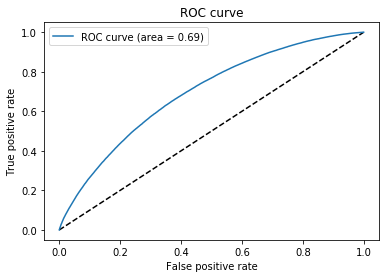

In [26]:
y_pred_log = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_log)
roc_auc=auc(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [37]:
Rf=RandomForestClassifier(n_estimators=100,min_samples_leaf=100,random_state=0).fit(X_train,y_train)
pred=Rf.predict(X_test)
y_pred_log = Rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_log)
roc_auc=auc(fpr,tpr)
print(classification_report(y_test,pred))
print(roc_auc)
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89    315389
           1       0.60      0.01      0.02     77128

    accuracy                           0.80    392517
   macro avg       0.70      0.50      0.46    392517
weighted avg       0.76      0.80      0.72    392517

0.6997775067181522
[[314875    514]
 [ 76351    777]]


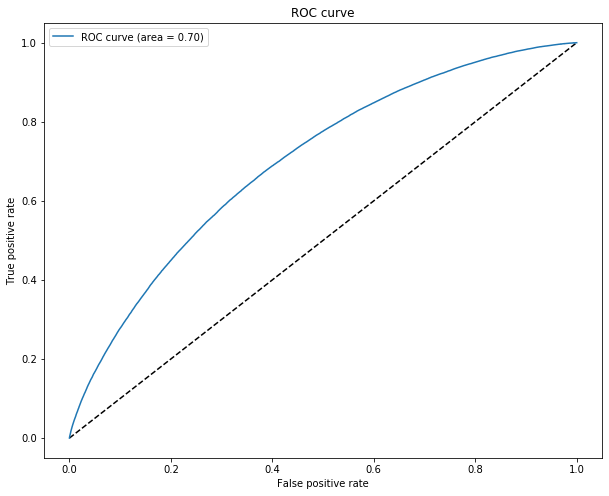

In [34]:
plt.figure(figsize=(10,8))
y_pred_log = Rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_log)
roc_auc=auc(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [38]:
Rf=RandomForestClassifier(class_weight="balanced",n_estimators=100,min_samples_leaf=100,random_state=0).fit(X_train,y_train)
pred=Rf.predict(X_test)
y_pred_log = Rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_log)
roc_auc=auc(fpr,tpr)
print(classification_report(y_test,pred))
print(roc_auc)
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.88      0.63      0.73    315389
           1       0.30      0.66      0.42     77128

    accuracy                           0.63    392517
   macro avg       0.59      0.64      0.57    392517
weighted avg       0.77      0.63      0.67    392517

0.6997674957924152
[[197245 118144]
 [ 25997  51131]]


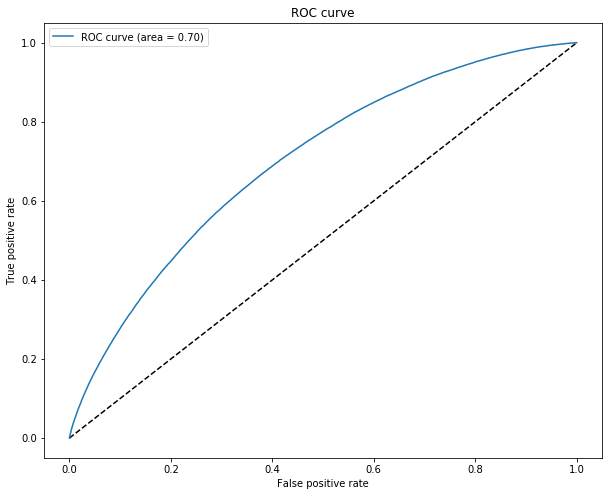

In [36]:
plt.figure(figsize=(10,8))
y_pred_log = Rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_log)
roc_auc=auc(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [59]:
BRf=RandomForestClassifier(n_estimators=100,min_samples_leaf=100,random_state=0,class_weight="balanced",n_jobs=-1).fit(X_train,y_train)
pred=BRf.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.88      0.63      0.73    252312
           1       0.30      0.66      0.41     61702

    accuracy                           0.63    314014
   macro avg       0.59      0.64      0.57    314014
weighted avg       0.77      0.63      0.67    314014



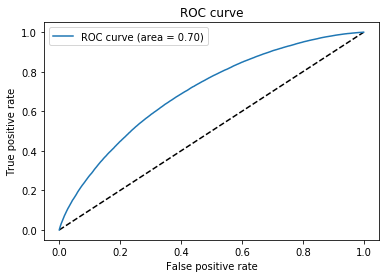

In [61]:
y_pred_log = BRf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_log)
roc_auc=auc(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [75]:
import lightgbm as lgbm
X_train1,X_test1,y_train1,y_test1=train_test_split(X_train, y_train, stratify = y_train, test_size = 0.25,random_state=0)
lgb_train = lgbm.Dataset(X_train1, y_train1)
lgb_eval = lgbm.Dataset(X_test1, y_test1, reference=lgb_train)

params = {
        'task': 'train',
        'objective': 'binary',    
        'metric': 'binary_error', 
        'verbose': 1
}
gbm = lgbm.train(params,
            lgb_train,
            num_boost_round=50,       
            early_stopping_rounds=10, 
            valid_sets=[lgb_train,lgb_eval],
            valid_names=['train', 'eval'])

[1]	train's binary_error: 0.196496	eval's binary_error: 0.196494
Training until validation scores don't improve for 10 rounds
[2]	train's binary_error: 0.196496	eval's binary_error: 0.196494
[3]	train's binary_error: 0.196496	eval's binary_error: 0.196494
[4]	train's binary_error: 0.196496	eval's binary_error: 0.196494
[5]	train's binary_error: 0.196496	eval's binary_error: 0.196494
[6]	train's binary_error: 0.196496	eval's binary_error: 0.196494
[7]	train's binary_error: 0.196496	eval's binary_error: 0.196494
[8]	train's binary_error: 0.196496	eval's binary_error: 0.196494
[9]	train's binary_error: 0.196496	eval's binary_error: 0.196494
[10]	train's binary_error: 0.196496	eval's binary_error: 0.196494
[11]	train's binary_error: 0.196496	eval's binary_error: 0.196494
Early stopping, best iteration is:
[1]	train's binary_error: 0.196496	eval's binary_error: 0.196494


In [ ]:
prediction = gbm.predict(X_test.values)


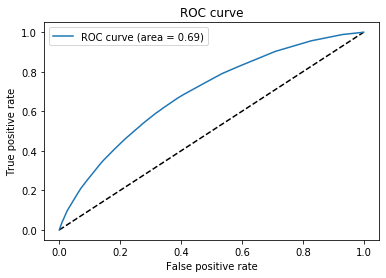

In [76]:

fpr, tpr, _ = roc_curve(y_test, prediction)
roc_auc=auc(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [69]:
model=MultinomialNB(fit_prior=False)
model.fit(X_train,y_train)
predicted=model.predict(X_test)
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.83      0.61      0.70    315389
           1       0.23      0.48      0.31     77128

    accuracy                           0.58    392517
   macro avg       0.53      0.55      0.51    392517
weighted avg       0.71      0.58      0.63    392517



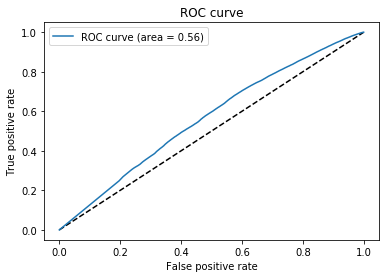

In [68]:
y_pred_log = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_log)
roc_auc=auc(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [39]:
GBC=GradientBoostingClassifier(loss="exponential",min_samples_leaf=100).fit(X_train,y_train)
predicted=GBC.predict(X_test)
y_pred_log = GBC.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_log)
roc_auc=auc(fpr,tpr)
print(classification_report(y_test,predicted))
print(roc_auc)
print(confusion_matrix(y_test,predicted))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89    315389
           1       0.56      0.03      0.06     77128

    accuracy                           0.80    392517
   macro avg       0.68      0.51      0.47    392517
weighted avg       0.76      0.80      0.73    392517

0.7000102557775751
[[313582   1807]
 [ 74828   2300]]


In [ ]:
GBC=GradientBoostingClassifier().fit(X_train,y_train)
predicted=GBC.predict(X_test)
y_pred_log = GBC.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_log)
roc_auc=auc(fpr,tpr)
print(classification_report(y_test,predicted))
print(roc_auc)
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))

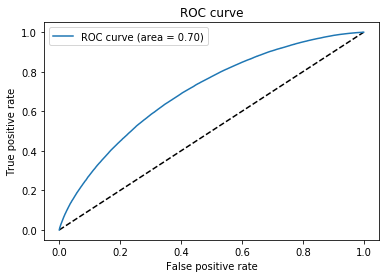

In [71]:
y_pred_log = GBC.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_log)
roc_auc=auc(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [73]:

def modelfit(alg, X_train,y_train, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    train_pred = alg.predict(X_train)
    train_prob = alg.predict_proba(X_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y_train, train_pred))
    print("AUC Score (Train): %f" % roc_auc_score(y_train, train_prob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8049
AUC Score (Train): 0.699712
CV Score : Mean - 0.6988527 | Std - 0.0006466597 | Min - 0.6979631 | Max - 0.6999554


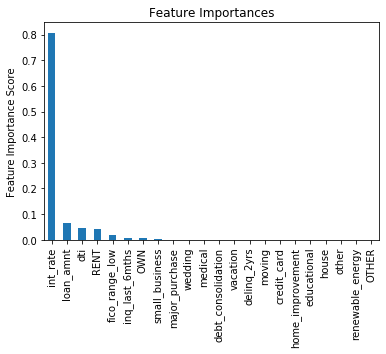

In [74]:
predictors = [i for i in X_train.columns]
gbm0 = GradientBoostingClassifier(random_state=0)
modelfit(gbm0, X_train,y_train, predictors)

In [148]:
#Choose all predictors except target & IDcols


AttributeError: 'Series' object has no attribute 'reshape'